# Interactive visualisation with Altair and Vega-Lite
+ date:2018-07-16
+ tags:streeteasy, python, vis
+ author:Philipp Kats
+ summary: Earlier this year we adopted Vega stack as our tool for data visualisation; In this notebook I'd like to go over a few examples of vis tools and helpers we created


Earlier this year we adopted Vega stack as our tool for data visualisation; In this notebook I'd like to go over a few examples of vis tools and helpers we created

**NOTE: For now all vis is static on the blog page. Use links below each plot to check interactive version. 
All charts will be interactive if you open this as a notebook (or copy code to your notebook)**

# 1. First, let's showcase some interactive charts from the gallery

In [16]:
import pandas as pd
import altair as alt
from vega_datasets import data

In [2]:
alt.__version__

'2.1.0'

All examples here are copied from [Altair Gallery](https://altair-viz.github.io/gallery/index.html)

## 1.1 Seattle Weather

In [3]:
scale = alt.Scale(domain=['sun', 'fog', 'drizzle', 'rain', 'snow'],
                  range=['#e7ba52', '#a7a7a7', '#aec7e8', '#1f77b4', '#9467bd'])
color = alt.Color('weather:N', scale=scale)

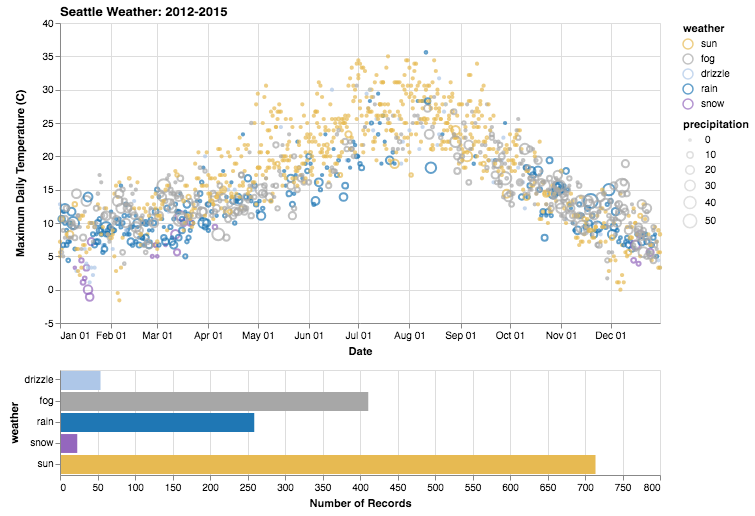

In [4]:
# We create two selections:
# - a brush that is active on the top panel
# - a multi-click that is active on the bottom panel
brush = alt.selection_interval(encodings=['x'])
click = alt.selection_multi(encodings=['color'])

# Top panel is scatter plot of temperature vs time
points = alt.Chart().mark_point().encode(
    alt.X('monthdate(date):T', axis=alt.Axis(title='Date')),
    alt.Y('temp_max:Q',
        axis=alt.Axis(title='Maximum Daily Temperature (C)'),
        scale=alt.Scale(domain=[-5, 40])
    ),
    color=alt.condition(brush, color, alt.value('lightgray')),
    size=alt.Size('precipitation:Q', scale=alt.Scale(range=[5, 200]))
).properties(
    width=600,
    height=300
).add_selection(
    brush
).transform_filter(
    click
)

# Bottom panel is a bar chart of weather type
bars = alt.Chart().mark_bar().encode(
    x='count()',
    y='weather:N',
    color=alt.condition(click, color, alt.value('lightgray')),
).transform_filter(
    brush
).properties(
    width=600,
).add_selection(
    click
)

chart = alt.vconcat(points, bars,
    data=data.seattle_weather.url,
    title="Seattle Weather: 2012-2015"
)  

chart

In [6]:
chart.save('../../static/seattle_vis.html')

[LINK](static/seattle_vis.html)

## 1.2 Crossfilters

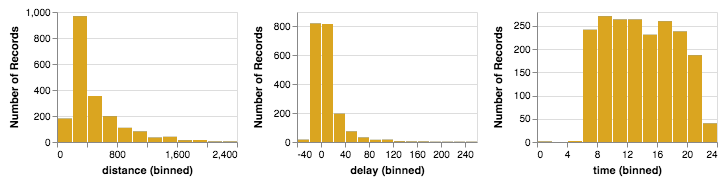

In [8]:

flights = alt.UrlData(data.flights_2k.url,
                      format={'parse': {'date': 'date'}})

brush = alt.selection(type='interval', encodings=['x'])

# Define the base chart, with the common parts of the
# background and highlights
base = alt.Chart().mark_bar().encode(
    x=alt.X(alt.repeat('column'), type='quantitative', bin=alt.Bin(maxbins=20)),
    y='count()'
).properties(
    width=180,
    height=130
)

# blue background with selection
background = base.properties(
    selection=brush
)

# yellow highlights on the transformed data
highlight = base.encode(
    color=alt.value('goldenrod')
).transform_filter(
    brush
)

# layer the two charts & repeat
chart = alt.layer(
    background, highlight,
    data=flights
).transform_calculate(
    "time", "hours(datum.date)"
).repeat(
    column=["distance", "delay", "time"]
)

chart

In [9]:
chart.save('../../static/crossfilter_vis.html')

[LINK](static/crossfilter_vis.html)

# 2. Now, let's see how to use altair and SE helpers to produce maps

In [10]:
from SE.vega import hoods, BOROUGHS
from SE.snowflake import _get_DF

In [11]:
Q = '''SELECT * from market_report where freq='Q' and report_date = '2018-03-31' and "fullDate" = '2018-01-01' ''' 
data = _get_DF(Q)

In [12]:
data.rename(columns={'areaID':'area_id'}, inplace=True)
len(data)

362

In [13]:
D = data.loc[data.medianAskingPrice.notnull(), ['area_id', 'medianAskingPrice']]
D.medianAskingPrice.isnull().any()

False

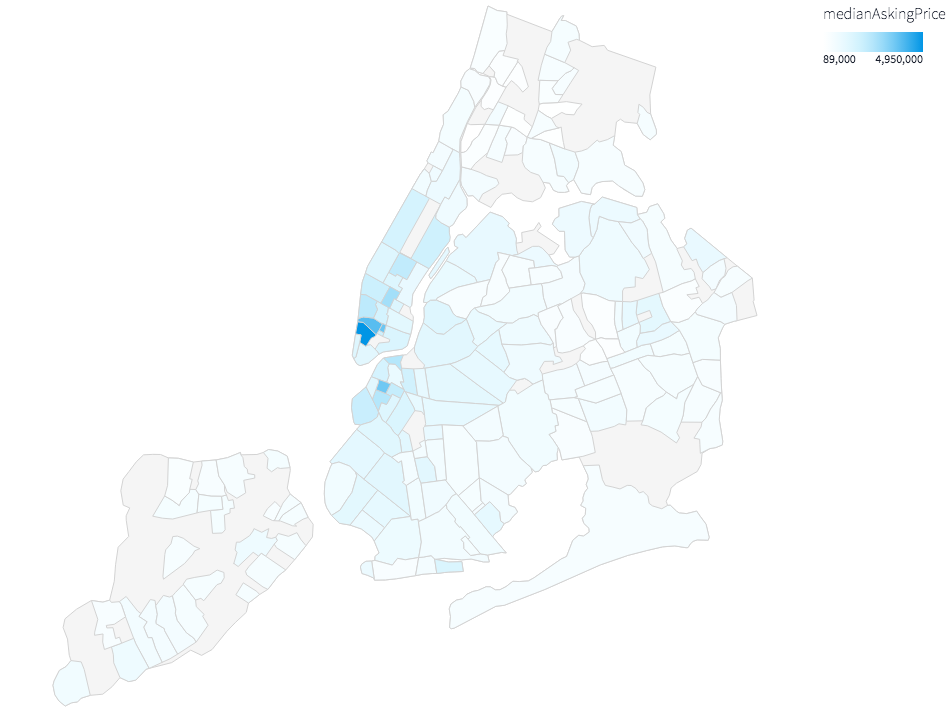

In [14]:
map_ = hoods(D)
BOROUGHS + map_.encode(color='medianAskingPrice:Q')

## 2.1 Repeat - minimaps

In [17]:
Q = '''SELECT "medianAskingPrice", "fullDate", "areaID" as area_id from market_report where freq='Q' and report_date = '2018-03-31';''' 
data = _get_DF(Q)

data['fullDate'] = pd.to_datetime(data['fullDate']).dt.to_period('Q').dt.strftime('%Y-Q%q')

In [18]:
data = data.set_index(['area_id', 'fullDate']).unstack()
data.columns = data.columns.get_level_values(-1)

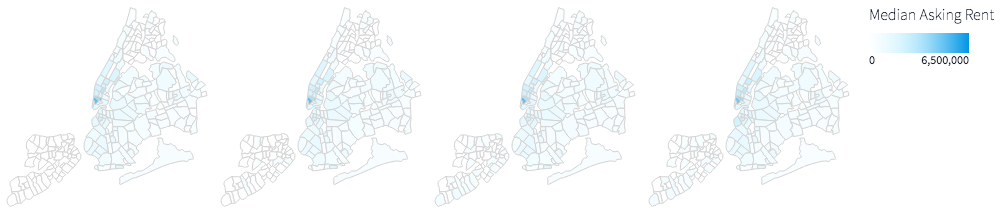

In [19]:
H = hoods(data.fillna(0).reset_index(drop=False))


H.encode(
    color=alt.Color(alt.repeat("column"), type='quantitative', title='Median Asking Rent')
).properties(
    width=200,
    height=200
).repeat(
    column=['2017-Q1', '2017-Q2', '2017-Q3', '2017-Q4']
)

# 3. Presentation

This is just a tiny fraction of what vega, vega-lite, and altair are capable of;

Below is the extended deck of slides for the presentation I gave on NYC DataVIs Meetup; 
Here, I made an attempt to articulate reasons StreetEasy moved from tableau to [Vega][1] stack as our production visualization platform.
I further explain the mere idea of declarative approach and the opportunities it gives. The rest of the slides cover Vega taxonomy, as well as different examples/pieces of large Vega family and an abstract scheme of StreetEasy Vega app.
 
[1]:	https://vega.github.io/

In [22]:
%%html
<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vSu7QiuJTFDmTwkpYkOCodJLLD0X9hcLwJxayYy0IvASHHyvJMOKmzsfZckAZTrXEYr2Efm84RXr0NZ/embed?start=false&loop=false&delayms=3000" frameborder="0" width="800" height="479" allowfullscreen="true" mozallowfullscreen="true"
webkitallowfullscreen="true"></iframe>